# walkthrough for beadops module
sample compression analysis with beadops module

## imports

In [1]:
# use autoreload for prototyping of beadops functions, automatically reload changes from module
%load_ext autoreload
%autoreload 2

In [2]:
# beadops module
import beadops.beadops as bo

In [3]:
# other modules used in this notebook
import pathlib
import pandas as pd
from vedo import *
import trackpy as tp
import matplotlib.pyplot as plt
import numpy as np

## specify data parameters
- parameters of recorded z-stack
- unit: microns per pixel

In [4]:
z_scale = 5 # 5 µm per z-plane diff
xy_scale = 0.605*2 # 2*0.6505 µm per px (10x, 2048x2048 px camera with 2x2 binning)

# 1. find beads

## analyze single z-stack
- used sample stack: 189 planes, 1024 x 1024 px per image, recorded at 10x with 2x2 binning
- analysis takes ~ 1 Min for this stack
- found bead positions saved as .pickle-file in outputfolder
- positions are filtered later (if changes in filtering done no repeated time-consuming analysis needed)
- locateparams = [(11,7,7)] used to estimate size of a bead to detect (11 planes in z, 7 px in x and y)

In [5]:
datafolder = pathlib.Path(r'D:\dev\beadops\sampledata\S1\5um-100mbar003-dz_5_00_um')
outputfolder = pathlib.Path(r'D:\dev\beadops\sampledata\raw_features')

bo.find_features(datafolder, outputfolder, [(11,7,7)])

loading z-stack in folder 5um-100mbar003-dz_5_00_um
analyze with parameters 11_7_7
skipping, already analyzed, rerun with overwrite kwarg if desired


## analyze multiple z-stacks stored in individual folders
- calls find_features on each folder in datafolder

In [6]:
datafolder = pathlib.Path(r'D:\dev\beadops\sampledata\S1')
outputfolder_rawfeatures = pathlib.Path(r'D:\dev\beadops\sampledata\raw_features')

bo.find_features_subfolders(datafolder, outputfolder_rawfeatures, [(11,7,7)])

finding features in subfolders: ['5um-00mbar002-dz_5_00_um', '5um-100mbar003-dz_5_00_um', '5um-200mbar004-dz_5_00_um', '5um-300mbar005-dz_5_00_um']
loading z-stack in folder 5um-00mbar002-dz_5_00_um
analyze with parameters 11_7_7
skipping, already analyzed, rerun with overwrite kwarg if desired
loading z-stack in folder 5um-100mbar003-dz_5_00_um
analyze with parameters 11_7_7
skipping, already analyzed, rerun with overwrite kwarg if desired
loading z-stack in folder 5um-200mbar004-dz_5_00_um
analyze with parameters 11_7_7
skipping, already analyzed, rerun with overwrite kwarg if desired
loading z-stack in folder 5um-300mbar005-dz_5_00_um
analyze with parameters 11_7_7
skipping, already analyzed, rerun with overwrite kwarg if desired


# 2. filter extracted beadpositions

## determine filter parameters from one z-stack

In [7]:
# load saved features, stored as pandas dataframe
features = pd.read_pickle(outputfolder_rawfeatures/'5um-100mbar003-dz_5_00_um-11_7_7.pickle')
features.head()

,z,y,x,mass,size_z,size_y,size_x,ecc,signal,raw_mass,ep_z,ep_y,ep_x
0,5.016524,3.303091,379.187271,968.750187,2.535489,1.910361,2.230382,NaN,21.639769,59672.0,-0.164569,-0.095723,-0.095723
1,5.195265,5.125079,258.337943,707.442570,2.851444,1.938235,2.122135,NaN,17.341458,56398.0,-0.153081,-0.089041,-0.089041
2,5.425711,4.895258,837.886617,703.292478,2.828502,1.961752,1.913294,NaN,15.118194,128519.0,0.284656,0.165573,0.165573
3,5.130078,7.832223,154.248288,1623.723729,2.861810,2.006789,2.235190,NaN,28.754213,58909.0,-0.161740,-0.094078,-0.094078
4,4.814278,8.123876,421.889521,807.637663,2.276855,2.255842,2.220047,NaN,20.602245,59668.0,-0.164554,-0.095715,-0.095715


In [8]:
# clean df columns, remove rows with nan value in x/y/z column
df = features.copy()
df = bo.clean_df(df)
df.head()

,x,y,z,signal
0,379.187271,3.303091,5.016524,21.639769
1,258.337943,5.125079,5.195265,17.341458
2,837.886617,4.895258,5.425711,15.118194
3,154.248288,7.832223,5.130078,28.754213
4,421.889521,8.123876,4.814278,20.602245


(0.0, 5000.0)

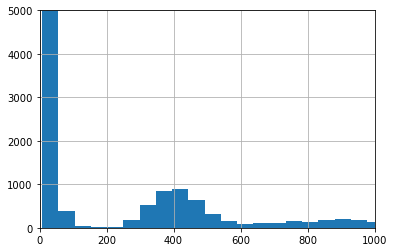

In [9]:
# plot histogram of signal intensities of detected beads to select cutoff for outliers
# here we manually adjust the scale extent with set_xlim/set_ylim to visualize the cut-off
# generally the intensity distribution depends on your dataset, such that it should be adjusted to the dataset
ax = bo.plot_signal(df, bins = 200)
ax.set_xlim(0,1000)
ax.set_ylim(0,5000)

In [10]:
# manually determined cutoff from histogram: 200
# set variable and filter beads 
min_signal = 200
df = bo.filter_df(df, min_signal = min_signal)

filtering particles from initially 57899 to 5929


In [11]:
# scale dataset
df = bo.scale_df(df, xy_scale, xy_scale, z_scale)

In [12]:
# check filtered dataset in 3D if wanted
# k3d has to be installed in version 2.7.4 (pip install k3d==2.7.4)
# you can vary your signal cutoff/ filtering parameters and check the effect on the dataset
# however always keep in mind that the df has been modified in the last jupyter cells,
# so it's best to start with features.copy() for iterating
bo.plot_pts_vedo(df, embed=True, r=7)

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0…

## filter all beadpositions from extracted z-stacks

In [13]:
# process all stack with the same parameters, save as .pickle in new folder filt_features
outputfolder_filtfeatures = outputfolder_rawfeatures.parent/"filt_features"
bo.filter_features_subfolders(outputfolder_rawfeatures, outputfolder_filtfeatures, xy_scale, z_scale, min_signal)

filter features from 5um-00mbar002-dz_5_00_um-11_7_7.pickle
filtering particles from initially 57959 to 5950
filter features from 5um-100mbar003-dz_5_00_um-11_7_7.pickle
filtering particles from initially 57899 to 5929
filter features from 5um-200mbar004-dz_5_00_um-11_7_7.pickle
filtering particles from initially 57794 to 5911
filter features from 5um-300mbar005-dz_5_00_um-11_7_7.pickle
filtering particles from initially 57960 to 5882


In [14]:
# if wanted you can reload those filtered beads and display them together in 3D
filt_files = list(outputfolder_filtfeatures.glob('*.pickle'))

# depending on your file naming scheme it might be useful to rename the import, here e.g. the pressure is extracted
# filtered beads saved in dict: {pressure:dataframe}
def parse_pressure(filename):
    pressure = filename.split("mbar")[0].split("um-")[1] # select number ### inbetween um- and mbar: um-###mbar
    pressure = int(pressure)
    return pressure

filt_features = {parse_pressure(file.stem): pd.read_pickle(file) for file in filt_files}
bo.plot_pts_vedo([filt_features[0],filt_features[100],filt_features[200],filt_features[300]], r=3, alpha=0.5,colors=["blue","teal","lime","orange"])

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0…

# 3. link particles

In [15]:
# link particles with trackpy
# filt_features is a dictionary with entries containing extracted particle positions (dataframes): {pressure:dataframe}
# loaded from folder filt_features in previous cells, each dictkey corresponds to the applied pressure

In [16]:
# specify linking order by list of dictionary keys (here: link according to increasing pressures 0, 100, 200, 300 mbar)
linkorder = [0,100,200,300]

linked_df = bo.link_particles(filt_features, linkorder, search_range = 15)

Frame 3: 5882 trajectories present.
linked particles: 6726
present in all frames: 5537


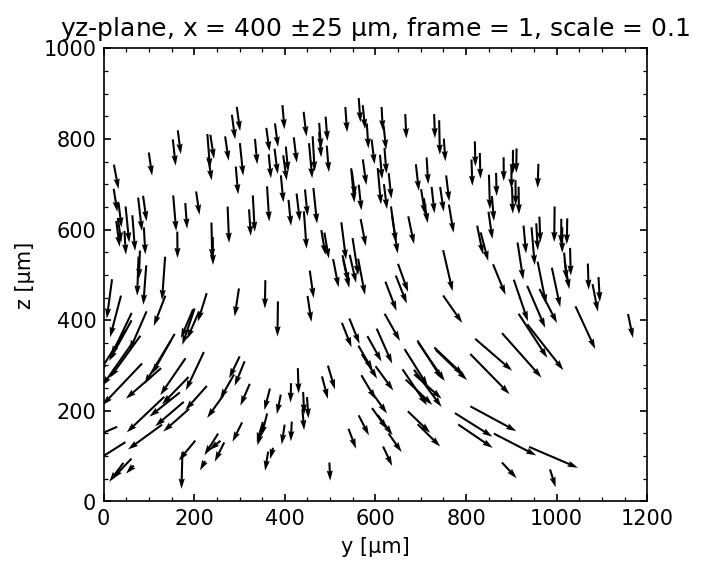

In [17]:
# check views of linked particles
# select a slice along x = 400 +- 25 µm
# linking between configuration at different pressures are mapped as linkging between "frames" in trackpy
# frame 1 corresponds to first pressure (100 mbar)
bo.plot_xslice(linked_df, 400, frame = 1, width=25, scale = 0.1, xlim=[0,1200],ylim=[0,1000])

In [18]:
# export slice view to a file
bo.plot_xslice(linked_df, 400, frame = 1, width=25, scale = 0.1, xlim = [0,1200],ylim=[0,1000], outputfolder = 'figs')

In [19]:
# if you want to export multiple slice views, you can just iterate:
for xpos in [0,200,400,600, 800]:
    bo.plot_xslice(linked_df, xpos, frame = 1, width=25, scale = 0.1, ylim=[0,900], outputfolder = 'raw_slices')

In [20]:
# show linked particles in 3D and highlight links with arrows
# to do: implement as function into bo

xyz0 = linked_df[linked_df["frame"]==0][["x","y","z"]].values
xyz1 = linked_df[linked_df["frame"]==1][["x","y","z"]].values
xyz2 = linked_df[linked_df["frame"]==2][["x","y","z"]].values
xyz3 = linked_df[linked_df["frame"]==3][["x","y","z"]].values

pts0 = Points(xyz0, c = "b", alpha = 0.5)
pts1 = Points(xyz1, c = "g", alpha = 0.5)
pts2 = Points(xyz2, c = "r", alpha = 0.5)
pts3 = Points(xyz3, c = "o", alpha = 0.5)

arr1 = shapes.Arrows(pts0, end_pts=pts1, s=None, c=None, alpha=1, res=12)
arr2 = shapes.Arrows(pts1, end_pts=pts2, s=None, c=None, alpha=1, res=12)
arr3 = shapes.Arrows(pts2, end_pts=pts3, s=None, c=None, alpha=1, res=12)

show(pts0, pts1, pts2, pts3, arr1, arr2, arr3, axes=1)

Plot(antialias=True, axes=['x', 'y', 'z'], axes_helper=1.0, background_color=16777215, camera=[2, -3, 0.2, 0.0…

# 4. interpolate displacements

In [21]:
# construct grid for interpolation
# grid should be chosen to roughly amount to the number of found particles
igridspacing = 50 # create evenly spaced grid of 50 points (-> here 20 µm steps)
grid = np.mgrid[0:1300:igridspacing, 0:1300:igridspacing, 0:1000:igridspacing]
# (if steplength complex: specifies number of points in interval, last point included)

In [22]:
# interpolate displacements
# saved in intdict as {frame:interpolated_arrays [component, x, y, z]}; component: ux/uy/uz=0/1/2
intdict = bo.interpolate_linear(linked_df, grid) # dict with interpolated displacements

interpolating frame 0
interpolating frame 1
interpolating frame 2
interpolating frame 3


50


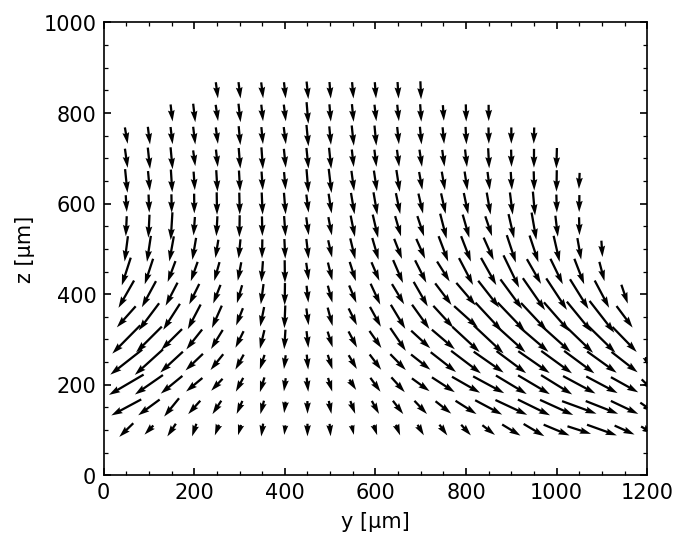

In [23]:
# plot interpolated displacement field
frame = 1
xpos = 400
fig, ax = bo.plot_xslice_int(intfield = intdict[frame], frame=frame, grid = grid, xpos=xpos, vmax=20, scale=.15, compression = None)#compdict[frame])
ax.set_xlim(0,1200)
ax.set_ylim(0,1000)
fig.savefig('figs/yz_x400_f1-int.png') # example for saving fig after manual modification

In [24]:
# or directly export interpolated displacement field, same syntax as previously
frame = 1
xpos = 400
bo.plot_xslice_int(intfield = intdict[frame], frame = frame, grid = grid, xpos=xpos, vmax=20, scale=.15, compression = None, outputfolder='int_slices')

50


# 5. calculate compression

In [25]:
# calculate compressions in 3D
# returns compdict: {pressure: compression[x/y/z]}
compdict = {frame: bo.calc_compression(disp, igridspacing = igridspacing) 
            for frame, disp in intdict.items() } # dict with compressions calculated from intict
# may return RuntimeWarning: invalid value encountered in det
# not crucial

C:\Users\ilorevilo\anaconda3\envs\py38\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


50


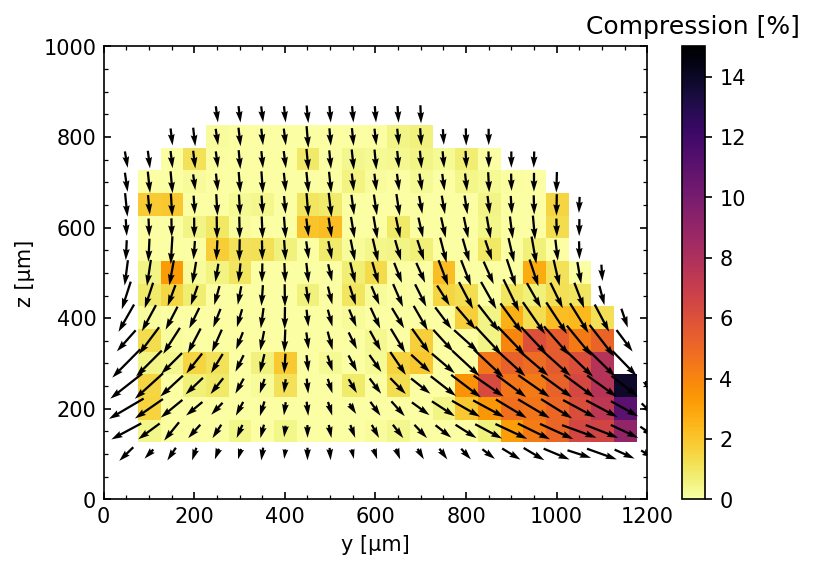

In [26]:
# plot compression planes
# Compression already inverted in plotting function -> pos. value = compression
frame = 1
xpos = 400
fig, ax = bo.plot_xslice_int(intfield = intdict[frame], frame = frame, grid = grid, xpos=xpos, vmin = 0, vmax=15, scale=.15, compression = compdict[frame])
ax.set_xlim(0,1200)
ax.set_ylim(0,1000)
fig.savefig('figs/yz_x400_f1-int-comp.png')

# 6. plot mean compression

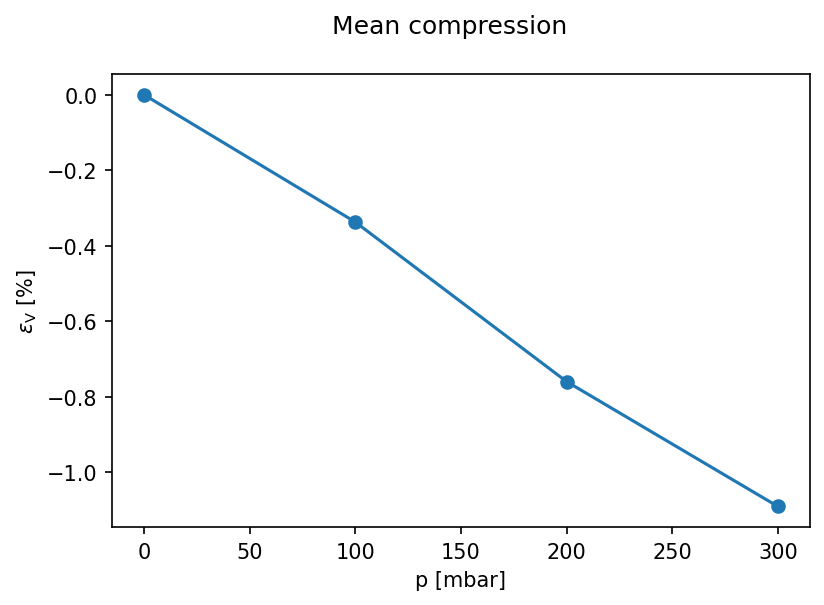

In [27]:
compressions_mean = {frame: np.nanmean(comp) for frame, comp in compdict.items()}
fig, ax = plt.subplots(dpi=150)
pressures = [0,100,200,300]
ax.plot(pressures, compressions_mean.values(), marker = 'o')
ax.set_xlabel("p [mbar]")
ax.set_ylabel(r"$\epsilon_{\mathrm{V}}$ [%]")
fig.suptitle("Mean compression")
fig.savefig('figs/mean_comp.png')